In [1]:
import os

# Move up one level to set the working directory to the repo root
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Suppress warning
os.environ["MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING"] = "false"

In [26]:
import pandas as pd
import numpy as np
import re
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, brier_score_loss

from src.data_processing import extract_game_info, extract_seed_value

In [5]:
# Load men's and women's seed data
m_seed = pd.read_csv(r"data\kaggle\MNCAATourneySeeds.csv")
w_seed = pd.read_csv(r"data\kaggle\WNCAATourneySeeds.csv")

# Extract numeric seed values
m_seed['SeedValue'] = m_seed['Seed'].apply(extract_seed_value)
w_seed['SeedValue'] = w_seed['Seed'].apply(extract_seed_value)

In [6]:
m_seed.head()

,Season,Seed,TeamID,SeedValue
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [3]:
# Load submission data
submission_df = pd.read_csv(r"data\kaggle\SampleSubmissionStage1.csv")
submission_df[['Season', 'TeamID1', 'TeamID2']] = submission_df['ID'].apply(extract_game_info).apply(pd.Series)

In [32]:
# Define function to determine gender based on TeamID1
def determine_gender(team_id):
    if str(team_id).startswith("1"):  # Men's teams start with 1
        return "Men"
    elif str(team_id).startswith("3"):  # Women's teams start with 3
        return "Women"
    else:
        return None  # Handle unexpected cases

# Assign Gender column
submission_df['Gender'] = submission_df['TeamID1'].apply(determine_gender)

# Split into men's and women's submission dataframes
m_submission = submission_df[submission_df['Gender'] == 'Men'].copy()
w_submission = submission_df[submission_df['Gender'] == 'Women'].copy()

# Merge with seed_df to get Seed Values
def merge_with_seed(sub_df, seed_df):
    sub_df = sub_df.merge(seed_df, left_on=['Season', 'TeamID1'], right_on=['Season', 'TeamID'], how='inner')
    sub_df = sub_df.rename(columns={'SeedValue': 'SeedA'}).drop(columns=['TeamID'])

    sub_df = sub_df.merge(seed_df, left_on=['Season', 'TeamID2'], right_on=['Season', 'TeamID'], how='inner')
    sub_df = sub_df.rename(columns={'SeedValue': 'SeedB'}).drop(columns=['TeamID'])

    # Compute Seed Difference
    sub_df['SeedDiff'] = sub_df['SeedA'] - sub_df['SeedB']
    sub_df['SeedDiff_Squared'] = sub_df['SeedDiff'] ** 2
    
    return sub_df

# Merge seed data for both men's and women's submissions
m_submission = merge_with_seed(m_submission, m_seed)
w_submission = merge_with_seed(w_submission, w_seed)


In [33]:
m_submission.head()

,ID,Pred,Season,TeamID1,TeamID2,Gender,Seed_x,SeedA,Seed_y,SeedB,SeedDiff,SeedDiff_Squared
0,2021_1101_1104,0.5,2021,1101,1104,Men,W14,14,W02,2,12,144
1,2021_1101_1111,0.5,2021,1101,1111,Men,W14,14,X16a,16,-2,4
2,2021_1101_1116,0.5,2021,1101,1116,Men,W14,14,Z03,3,11,121
3,2021_1101_1124,0.5,2021,1101,1124,Men,W14,14,Z01,1,13,169
4,2021_1101_1140,0.5,2021,1101,1140,Men,W14,14,W06,6,8,64


In [9]:
# Load tournament results data
m_results = pd.read_csv(r"data\kaggle\MNCAATourneyCompactResults.csv")
w_results = pd.read_csv(r"data\kaggle\WNCAATourneyCompactResults.csv")

In [10]:
m_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [34]:
def process_results(results_df, seed_df):
    """Process results to generate SeedDiff and matchups from both perspectives."""
    results_df = results_df.merge(seed_df, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    results_df = results_df.rename(columns={'SeedValue': 'SeedA'}).drop(columns=['TeamID'])

    results_df = results_df.merge(seed_df, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
    results_df = results_df.rename(columns={'SeedValue': 'SeedB'}).drop(columns=['TeamID'])

    # Ensure TeamA has the lower ID
    results_df['TeamA'] = results_df[['WTeamID', 'LTeamID']].min(axis=1)
    results_df['TeamB'] = results_df[['WTeamID', 'LTeamID']].max(axis=1)

    # Generate Matchup ID
    results_df['MatchupID'] = results_df.apply(lambda row: f"{row['Season']}_{row['TeamA']}_{row['TeamB']}", axis=1)

    # Compute Seed Difference
    results_df['SeedDiff'] = results_df['SeedA'] - results_df['SeedB']
    results_df['SeedDiff_Squared'] = results_df['SeedDiff'] ** 2

    # Define Outcome (1 if TeamA won, 0 otherwise)
    results_df['Outcome'] = (results_df['TeamA'] == results_df['WTeamID']).astype(int)

    # Create a flipped version from TeamB’s perspective
    flipped_results = results_df.copy()
    flipped_results['MatchupID'] = flipped_results.apply(lambda row: f"{row['Season']}_{row['TeamB']}_{row['TeamA']}", axis=1)
    flipped_results['SeedDiff'] = -flipped_results['SeedDiff']
    flipped_results['Outcome'] = 1 - flipped_results['Outcome']

    # Combine original and flipped datasets
    final_results = pd.concat([results_df, flipped_results], axis=0).reset_index(drop=True)

    return final_results[['MatchupID', 'Season', 'SeedDiff', 'SeedDiff_Squared', 'Outcome']]

# Process men's and women's tournament results separately
m_model_data = process_results(m_results, m_seed)
w_model_data = process_results(w_results, w_seed)

In [35]:
m_model_data.head()

,MatchupID,Season,SeedDiff,SeedDiff_Squared,Outcome
0,1985_1116_1234,1985,1,1,1
1,1985_1120_1345,1985,5,25,1
2,1985_1207_1250,1985,-15,225,1
3,1985_1229_1425,1985,1,1,1
4,1985_1242_1325,1985,-11,121,1


In [ ]:
new_experiment_id = mlflow.create_experiment("SeedDiff_Model")
print(f"New Experiment ID: {new_experiment_id}")

mlflow.set_experiment("SeedDiff_Model")

In [22]:
def train_seed_diff_model(model_data, gender):
    """Train a logistic regression model on SeedDiff for men's or women's tournament."""
    for season in range(2021, 2025):  # Predicting for 2021-2024
        train_data = model_data[model_data['Season'] < season].copy()

        # Ensure `SeedDiff` is float64
        X_train = pd.DataFrame(train_data[['SeedDiff']], columns=['SeedDiff']).astype("float64")

        # Ensure `Outcome` is float64 (important for MLflow schema consistency)
        y_train = train_data['Outcome'].astype("float64")

        with mlflow.start_run(run_name=f"{gender}_SeedDiff_Season_{season}"):
            # Train Model
            model = LogisticRegression()
            model.fit(X_train, y_train)

            # Log Metrics
            mlflow.log_param("Season", season)
            mlflow.log_param("Gender", gender)
            mlflow.log_param("Train Size", len(X_train))
            mlflow.log_metric("SeedDiff_Mean", X_train.mean().values[0])

            # Log Model with correct input schema
            input_example = pd.DataFrame([[0.0]], columns=["SeedDiff"])  # Ensure it's float
            mlflow.sklearn.log_model(model, f"{gender}_SeedDiff_Model_{season}", input_example=input_example)

            print(f"{gender} model trained for season {season}")

# Train men's and women's models separately
train_seed_diff_model(m_model_data, "Men")
train_seed_diff_model(w_model_data, "Women")


Men model trained for season 2021


Men model trained for season 2022


Men model trained for season 2023


Men model trained for season 2024


Women model trained for season 2021


Women model trained for season 2022


Women model trained for season 2023


Women model trained for season 2024


In [28]:
def train_seed_diff_model(model_data, gender):
    """Train a logistic regression model on SeedDiff for men's or women's tournament."""
    for season in range(2021, 2025):  # Predicting for 2021-2024
        train_data = model_data[model_data['Season'] < season].copy()
        test_data = model_data[model_data['Season'] == season].copy()

        # Ensure SeedDiff is float64
        X_train = pd.DataFrame(train_data[['SeedDiff']], columns=['SeedDiff']).astype("float64")
        y_train = train_data['Outcome'].astype("float64")

        X_test = pd.DataFrame(test_data[['SeedDiff']], columns=['SeedDiff']).astype("float64")
        y_test = test_data['Outcome'].astype("float64")

        with mlflow.start_run(run_name=f"{gender}_SeedDiff_Season_{season}"):
            # Train Model
            model = LogisticRegression()
            model.fit(X_train, y_train)

            # Make Predictions
            y_pred_probs = model.predict_proba(X_test)[:, 1]  # Probability of TeamA winning
            y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Convert to binary (win/loss)

            # Compute Metrics
            log_loss_value = log_loss(y_test, y_pred_probs)  # Main Kaggle metric
            accuracy_value = accuracy_score(y_test, y_pred_labels)  # General model accuracy
            auc_value = roc_auc_score(y_test, y_pred_probs)  # AUC score
            brier_value = brier_score_loss(y_test, y_pred_probs)  # Calibration metric
            baseline_log_loss = log_loss(y_test, np.full_like(y_test, 0.5))  # Log Loss of a dummy 50/50 predictor

            # Log Metrics
            mlflow.log_param("Season", season)
            mlflow.log_param("Gender", gender)
            mlflow.log_param("Train Size", len(X_train))
            mlflow.log_metric("SeedDiff_Mean", X_train.mean().values[0])
            mlflow.log_metric("Log_Loss", log_loss_value)
            mlflow.log_metric("Accuracy", accuracy_value)
            mlflow.log_metric("AUC", auc_value)
            mlflow.log_metric("Brier_Score", brier_value)
            mlflow.log_metric("Baseline_Log_Loss", baseline_log_loss)

            # Log Model with correct input schema
            input_example = pd.DataFrame([[0.0]], columns=["SeedDiff"])  # Ensure it's float
            mlflow.sklearn.log_model(model, f"{gender}_SeedDiff_Model_{season}", input_example=input_example)

            print(f"{gender} model trained for season {season}")
            print(f"Log Loss: {log_loss_value:.4f}, Accuracy: {accuracy_value:.4f}, AUC: {auc_value:.4f}, Brier Score: {brier_value}, Baseline Log Loss: {baseline_log_loss}")

# Train men's and women's models separately
train_seed_diff_model(m_model_data, "Men")
train_seed_diff_model(w_model_data, "Women")


Men model trained for season 2021
Log Loss: 0.6933, Accuracy: 0.3712, AUC: 0.3527, Brier Score: 0.250078938035328, Baseline Log Loss: 0.6931471805599454


Men model trained for season 2022
Log Loss: 0.6921, Accuracy: 0.5522, AUC: 0.5805, Brier Score: 0.24947010745831105, Baseline Log Loss: 0.6931471805599454


Men model trained for season 2023
Log Loss: 0.6920, Accuracy: 0.5522, AUC: 0.5636, Brier Score: 0.2494324563335187, Baseline Log Loss: 0.6931471805599454


Men model trained for season 2024
Log Loss: 0.6888, Accuracy: 0.6194, AUC: 0.6882, Brier Score: 0.24782111957101957, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2021
Log Loss: 0.6935, Accuracy: 0.5000, AUC: 0.4390, Brier Score: 0.2501855339653524, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2022
Log Loss: 0.6938, Accuracy: 0.3806, AUC: 0.3318, Brier Score: 0.2503201237221862, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2023
Log Loss: 0.6913, Accuracy: 0.5970, AUC: 0.6039, Brier Score: 0.24908826532990125, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2024
Log Loss: 0.6893, Accuracy: 0.6045, AUC: 0.6319, Brier Score: 0.24805537579184203, Baseline Log Loss: 0.6931471805599454


In [29]:
# Apply the trained model to predict probabilities

# Get the correct experiment ID dynamically
experiment = mlflow.get_experiment_by_name("SeedDiff_Model")
experiment_id = experiment.experiment_id  # Correct experiment folder (e.g., 835737634426971665)

for season in range(2021, 2025):  # Predicting for 2021-2024
    for gender, test_df in [('Men', m_submission), ('Women', w_submission)]:
        # Ensure a deep copy to avoid SettingWithCopyWarning
        season_test_df = test_df[test_df['Season'] == season].copy()
        X_test = season_test_df[['SeedDiff']]

        # Ensure X_test is a DataFrame with column names
        X_test = pd.DataFrame(X_test, columns=['SeedDiff']).astype("float64")

        with mlflow.start_run(run_name=f"{gender}_SeedDiff_Prediction_{season}"):
            try:
                # Search for the latest run ID for this experiment
                runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["start_time DESC"])

                # Find the model corresponding to this season and gender
                model_run = runs[runs['tags.mlflow.runName'] == f"{gender}_SeedDiff_Season_{season}"]
                if model_run.empty:
                    raise FileNotFoundError(f"No trained model found for {gender} Season {season}")

                run_id = model_run.iloc[0]['run_id']
                model_path = f"mlruns/{experiment_id}/{run_id}/artifacts/{gender}_SeedDiff_Model_{season}"

                # Load model dynamically
                model = mlflow.sklearn.load_model(model_path)

                # Predict probabilities
                season_test_df.loc[:, 'Pred'] = model.predict_proba(X_test)[:, 1]

                # Update the submission dataframe
                if gender == "Men":
                    m_submission.loc[m_submission['Season'] == season, 'Pred'] = season_test_df['Pred']
                else:
                    w_submission.loc[w_submission['Season'] == season, 'Pred'] = season_test_df['Pred']

                print(f"Predictions made for {gender} Season {season} using model {run_id}")

            except Exception as e:
                print(f"Error loading model for {gender} Season {season}: {e}")


Predictions made for Men Season 2021 using model 5946e216373043d59c3e2b4ae020590d
Predictions made for Women Season 2021 using model 231eb2e1ff2c43689b96e271779ef5e2
Predictions made for Men Season 2022 using model 0b141e70c2f84119adc18de2ea46fca1
Predictions made for Women Season 2022 using model 06b1f55d6def467286e8c4e9378b9541
Predictions made for Men Season 2023 using model 461605b059f742ad8fd4a7338780c42b
Predictions made for Women Season 2023 using model 208da4bf9029462f9f05dc779eca3ac0
Predictions made for Men Season 2024 using model afa407d1fd7e4af59cbcff638ea617d2
Predictions made for Women Season 2024 using model e0e569e7bf68412bae79bb927a939ef8


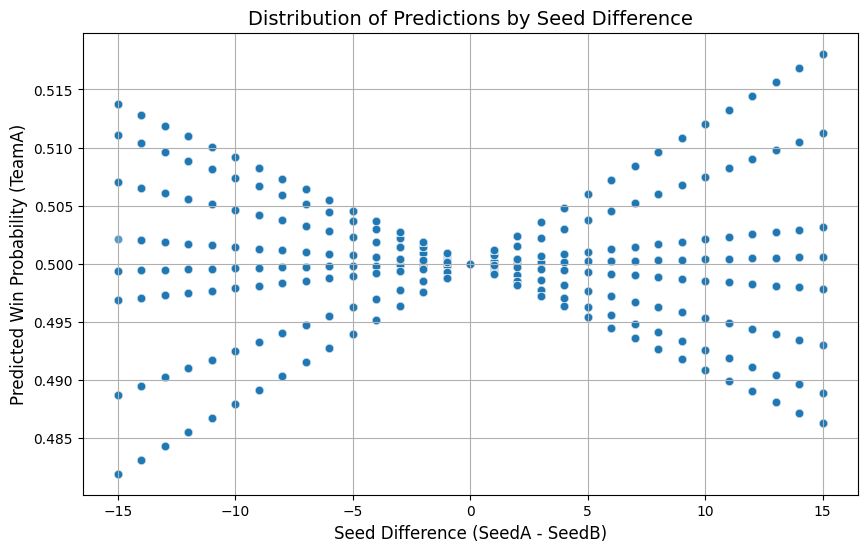

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine men's and women's submission data for visualization
submission_combined = pd.concat([m_submission, w_submission], ignore_index=True)

# Create a scatterplot showing Pred vs. SeedDiff
plt.figure(figsize=(10, 6))
sns.scatterplot(data=submission_combined, x="SeedDiff", y="Pred", alpha=0.5)

# Add titles and labels
plt.title("Distribution of Predictions by Seed Difference", fontsize=14)
plt.xlabel("Seed Difference (SeedA - SeedB)", fontsize=12)
plt.ylabel("Predicted Win Probability (TeamA)", fontsize=12)

# Show the plot
plt.grid(True)
plt.show()


In [31]:
import pandas as pd

# Combine men's and women's submission data for analysis
submission_combined = pd.concat([m_submission, w_submission], ignore_index=True)

# Compute absolute value of SeedDiff
submission_combined["Abs_SeedDiff"] = submission_combined["SeedDiff"].abs()

# Group by absolute seed difference and calculate min, max, and average probability
seed_diff_stats = (
    submission_combined.groupby("Abs_SeedDiff")["Pred"]
    .agg(["min", "max", "mean"])
    .reset_index()
)

# Rename columns for clarity
seed_diff_stats.columns = ["Abs_SeedDiff", "Min_Prob", "Max_Prob", "Avg_Prob"]

# Display the DataFrame
display(seed_diff_stats)

# Optionally, save to CSV for further analysis
# seed_diff_stats.to_csv("seed_diff_probability_stats.csv", index=False)


,Abs_SeedDiff,Min_Prob,Max_Prob,Avg_Prob
0,0,0.500000,0.500000,0.500000
1,1,0.498795,0.501205,0.500017
2,2,0.497590,0.502410,0.500014
3,3,0.496384,0.503616,0.500004
4,4,0.495179,0.504821,0.500166
5,5,0.493974,0.506026,0.500245
6,6,0.492769,0.507231,0.500268
7,7,0.491564,0.508436,0.500080
8,8,0.490359,0.509641,0.500461
9,9,0.489155,0.510845,0.500137


In [ ]:
# Keep only required columns for Kaggle submission
submission_df[['ID', 'Pred']].to_csv("SeedDiff_Model_Submission.csv", index=False)


In [ ]:
new_experiment_id = mlflow.create_experiment("SeedDiff_Squared_Model")
print(f"New Experiment ID: {new_experiment_id}")

mlflow.set_experiment("SeedDiff_Squared_Model")

In [39]:
def train_seed_diff_squared_model(model_data, gender):
    """Train a logistic regression model on SeedDiff_Squared for men's or women's tournament."""
    for season in range(2021, 2025):  # Predicting for 2021-2024
        train_data = model_data[model_data['Season'] < season].copy()
        test_data = model_data[model_data['Season'] == season].copy()

        # Ensure SeedDiff is float64
        X_train = pd.DataFrame(train_data[['SeedDiff_Squared']], columns=['SeedDiff_Squared']).astype("float64")
        y_train = train_data['Outcome'].astype("float64")

        X_test = pd.DataFrame(test_data[['SeedDiff_Squared']], columns=['SeedDiff_Squared']).astype("float64")
        y_test = test_data['Outcome'].astype("float64")

        with mlflow.start_run(run_name=f"{gender}_SeedDiff_Squared_Season_{season}"):
            # Train Model
            model = LogisticRegression()
            model.fit(X_train, y_train)

            # Make Predictions
            y_pred_probs = model.predict_proba(X_test)[:, 1]  # Probability of TeamA winning
            y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Convert to binary (win/loss)

            # Compute Metrics
            log_loss_value = log_loss(y_test, y_pred_probs)  # Main Kaggle metric
            accuracy_value = accuracy_score(y_test, y_pred_labels)  # General model accuracy
            auc_value = roc_auc_score(y_test, y_pred_probs)  # AUC score
            brier_value = brier_score_loss(y_test, y_pred_probs)  # Calibration metric
            baseline_log_loss = log_loss(y_test, np.full_like(y_test, 0.5))  # Log Loss of a dummy 50/50 predictor

            # Log Metrics
            mlflow.log_param("Season", season)
            mlflow.log_param("Gender", gender)
            mlflow.log_param("Train Size", len(X_train))
            mlflow.log_metric("SeedDiff_Squared_Mean", X_train.mean().values[0])
            mlflow.log_metric("Log_Loss", log_loss_value)
            mlflow.log_metric("Accuracy", accuracy_value)
            mlflow.log_metric("AUC", auc_value)
            mlflow.log_metric("Brier_Score", brier_value)
            mlflow.log_metric("Baseline_Log_Loss", baseline_log_loss)

            # Log Model with correct input schema
            input_example = pd.DataFrame([[0.0]], columns=["SeedDiff_Squared"])  # Ensure it's float
            mlflow.sklearn.log_model(model, f"{gender}_SeedDiff_Squared_Model_{season}", input_example=input_example)

            print(f"{gender} model trained for season {season}")
            print(f"Log Loss: {log_loss_value:.4f}, Accuracy: {accuracy_value:.4f}, AUC: {auc_value:.4f}, Brier Score: {brier_value}, Baseline Log Loss: {baseline_log_loss}")

# Train men's and women's models separately
train_seed_diff_squared_model(m_model_data, "Men")
train_seed_diff_squared_model(w_model_data, "Women")

Men model trained for season 2021
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Men model trained for season 2022
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Men model trained for season 2023
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Men model trained for season 2024
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2021
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2022
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2023
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


Women model trained for season 2024
Log Loss: 0.6931, Accuracy: 0.5000, AUC: 0.5000, Brier Score: 0.25, Baseline Log Loss: 0.6931471805599454


In [40]:
# Apply the trained model to predict probabilities

# Get the correct experiment ID dynamically
experiment = mlflow.get_experiment_by_name("SeedDiff_Squared_Model")
experiment_id = experiment.experiment_id  # Correct experiment folder (e.g., 835737634426971665)

for season in range(2021, 2025):  # Predicting for 2021-2024
    for gender, test_df in [('Men', m_submission), ('Women', w_submission)]:
        # Ensure a deep copy to avoid SettingWithCopyWarning
        season_test_df = test_df[test_df['Season'] == season].copy()
        X_test = season_test_df[['SeedDiff_Squared']]

        # Ensure X_test is a DataFrame with column names
        X_test = pd.DataFrame(X_test, columns=['SeedDiff_Squared']).astype("float64")

        with mlflow.start_run(run_name=f"{gender}_SeedDiff_Squared_Prediction_{season}"):
            try:
                # Search for the latest run ID for this experiment
                runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["start_time DESC"])

                # Find the model corresponding to this season and gender
                model_run = runs[runs['tags.mlflow.runName'] == f"{gender}_SeedDiff_Squared_Season_{season}"]
                if model_run.empty:
                    raise FileNotFoundError(f"No trained model found for {gender} Season {season}")

                run_id = model_run.iloc[0]['run_id']
                model_path = f"mlruns/{experiment_id}/{run_id}/artifacts/{gender}_SeedDiff_Squared_Model_{season}"

                # Load model dynamically
                model = mlflow.sklearn.load_model(model_path)

                # Predict probabilities
                season_test_df.loc[:, 'Pred'] = model.predict_proba(X_test)[:, 1]

                # Update the submission dataframe
                if gender == "Men":
                    m_submission.loc[m_submission['Season'] == season, 'Pred'] = season_test_df['Pred']
                else:
                    w_submission.loc[w_submission['Season'] == season, 'Pred'] = season_test_df['Pred']

                print(f"Predictions made for {gender} Season {season} using model {run_id}")

            except Exception as e:
                print(f"Error loading model for {gender} Season {season}: {e}")


Predictions made for Men Season 2021 using model 9347db146ee746aead001c514ca9ca8b
Predictions made for Women Season 2021 using model 3a545e94142f4b2abd55fbb141a5500d
Predictions made for Men Season 2022 using model 32a6d6510c0e47ce963e62e2591cf0fa
Predictions made for Women Season 2022 using model 4cff67cb71814d17902810fc7091e788
Predictions made for Men Season 2023 using model 2916aaeff3154166a35148aed411de51
Predictions made for Women Season 2023 using model 81fd4455e0a84e7dbce004d0ad9f0da1
Predictions made for Men Season 2024 using model efa8bffd6f0b4870ad35db54e64c8385
Predictions made for Women Season 2024 using model c750593361ea4c45957c3dff69a2ab67


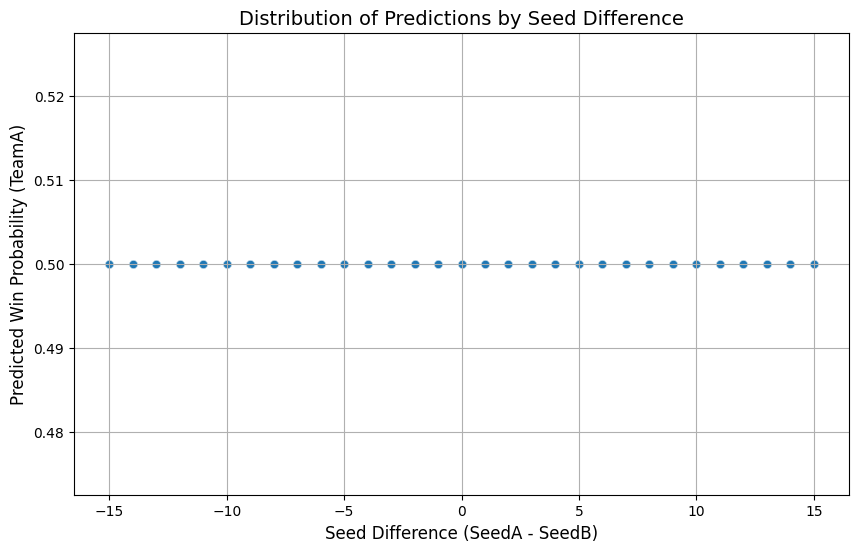

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine men's and women's submission data for visualization
submission_combined = pd.concat([m_submission, w_submission], ignore_index=True)

# Create a scatterplot showing Pred vs. SeedDiff
plt.figure(figsize=(10, 6))
sns.scatterplot(data=submission_combined, x="SeedDiff", y="Pred", alpha=0.5)

# Add titles and labels
plt.title("Distribution of Predictions by Seed Difference", fontsize=14)
plt.xlabel("Seed Difference (SeedA - SeedB)", fontsize=12)
plt.ylabel("Predicted Win Probability (TeamA)", fontsize=12)

# Show the plot
plt.grid(True)
plt.show()


In [42]:
import pandas as pd

# Combine men's and women's submission data for analysis
submission_combined = pd.concat([m_submission, w_submission], ignore_index=True)

# Compute absolute value of SeedDiff
submission_combined["Abs_SeedDiff"] = submission_combined["SeedDiff"].abs()

# Group by absolute seed difference and calculate min, max, and average probability
seed_diff_stats = (
    submission_combined.groupby("Abs_SeedDiff")["Pred"]
    .agg(["min", "max", "mean"])
    .reset_index()
)

# Rename columns for clarity
seed_diff_stats.columns = ["Abs_SeedDiff", "Min_Prob", "Max_Prob", "Avg_Prob"]

# Display the DataFrame
display(seed_diff_stats)

# Optionally, save to CSV for further analysis
# seed_diff_stats.to_csv("seed_diff_probability_stats.csv", index=False)


,Abs_SeedDiff,Min_Prob,Max_Prob,Avg_Prob
0,0,0.5,0.5,0.5
1,1,0.5,0.5,0.5
2,2,0.5,0.5,0.5
3,3,0.5,0.5,0.5
4,4,0.5,0.5,0.5
5,5,0.5,0.5,0.5
6,6,0.5,0.5,0.5
7,7,0.5,0.5,0.5
8,8,0.5,0.5,0.5
9,9,0.5,0.5,0.5
